In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px

In [40]:
df = pd.read_csv("../data/benin-malanville.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [15]:
# Basic structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

In [16]:
# Summary stats for all numeric columns
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-02-07 12:00:30.000000512,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
min,2021-08-09 00:01:00,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,2021-11-08 06:00:45,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,2022-02-07 12:00:30,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN
std,NaN,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN


In [30]:
# Count of missing values in each column
missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100

# Show only columns with more than 5% missing values
missing_over_5 = missing_percent[missing_percent > 5]

print("\n🔍 Missing Values (%):")
print(missing_percent.sort_values(ascending=False))
print("\n⚠️ Columns with >5% missing:")
print(missing_over_5)


🔍 Missing Values (%):
Comments         100.0
GHI                0.0
Timestamp          0.0
DNI                0.0
DHI                0.0
ModB               0.0
ModA               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
Tamb               0.0
WSstdev            0.0
WD                 0.0
BP                 0.0
WDstdev            0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
dtype: float64

⚠️ Columns with >5% missing:
Comments    100.0
dtype: float64


In [41]:
# Drop the 'Comments' column
df.drop(columns=["Comments"], inplace=True)
print("Dropped 'Comments' column — it was completely empty.")

Dropped 'Comments' column — it was completely empty.


In [42]:
from scipy.stats import zscore

# Define columns to check for outliers
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Repeat until no outliers remain or the number stops decreasing
previous_count = -1
max_loops = 10
loop = 0

while loop < max_loops:
    z_scores = df[columns_to_check].apply(zscore)
    outlier_mask = z_scores.abs() > 3
    current_count = outlier_mask.any(axis=1).sum()

    if current_count == 0 or current_count == previous_count:
        break

    for col in columns_to_check:
        median = df[col].median()
        df.loc[outlier_mask[col], col] = median

    previous_count = current_count
    loop += 1

print(f"Final outlier count after cleanup: {(df[columns_to_check].apply(zscore).abs() > 3).any(axis=1).sum()}")



Final outlier count after cleanup: 22


In [43]:
# Final cleanup: drop the few remaining outliers
z_scores_final = df[columns_to_check].apply(zscore)
outlier_mask_final = z_scores_final.abs() > 3
df_clean = df[~outlier_mask_final.any(axis=1)]

In [57]:
df_clean.to_csv("../data/benin_clean.csv", index=False)

<Figure size 1600x800 with 0 Axes>

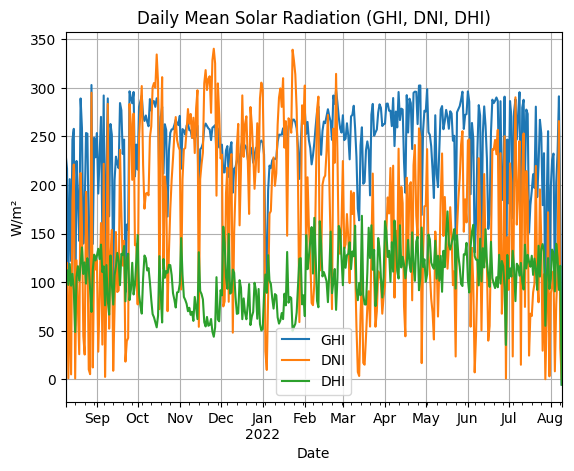

In [44]:
# Set timestamp as index for easy plotting
df_clean = df_clean.sort_values("Timestamp")
df_clean.set_index("Timestamp", inplace=True)

# Plotting
plt.figure(figsize=(16, 8))
df_clean[["GHI", "DNI", "DHI"]].resample("D").mean().plot()
plt.title("Daily Mean Solar Radiation (GHI, DNI, DHI)")
plt.ylabel("W/m²")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show()



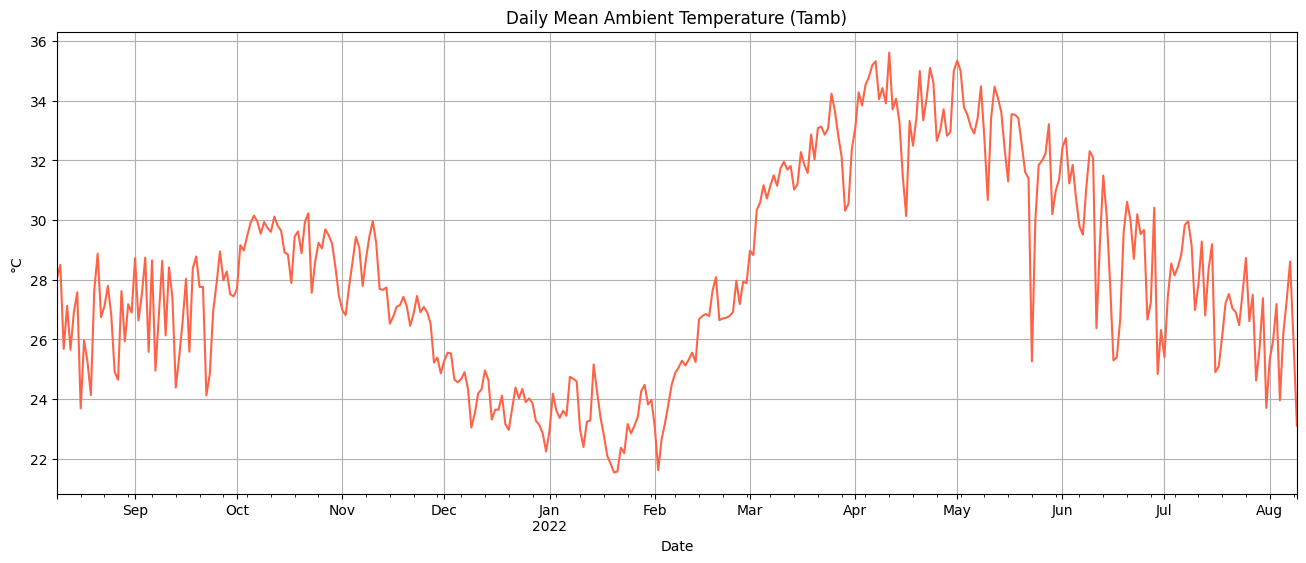

In [45]:
# Temperature over time
plt.figure(figsize=(16, 6))
df_clean["Tamb"].resample("D").mean().plot(color="tomato")
plt.title("Daily Mean Ambient Temperature (Tamb)")
plt.ylabel("°C")
plt.xlabel("Date")
plt.grid(True)
plt.show()


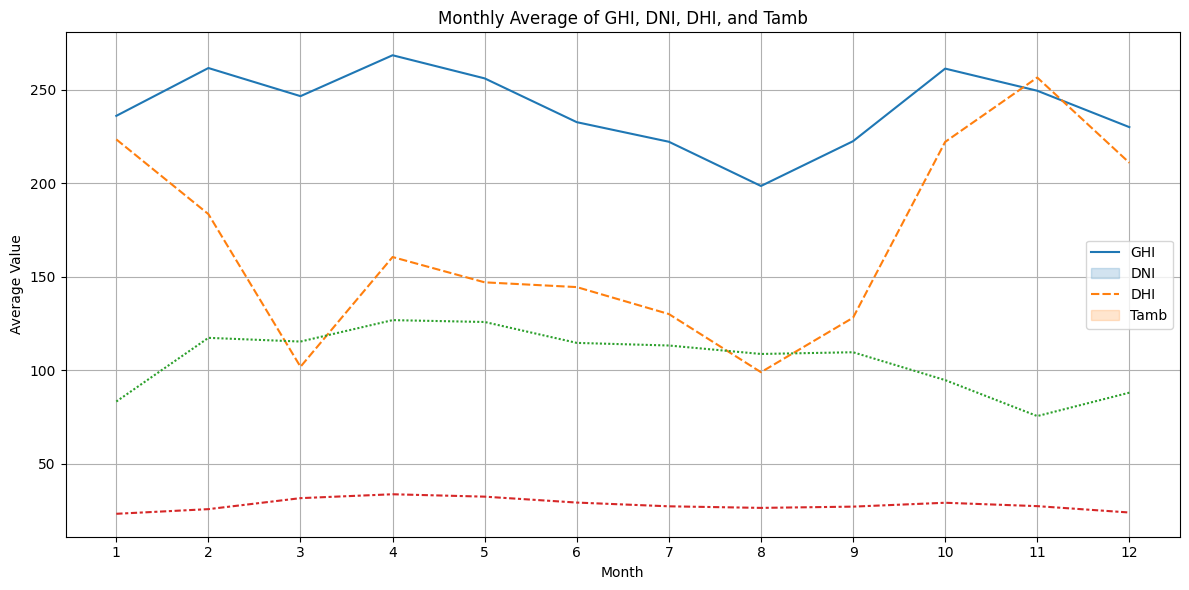

In [46]:
# Add a 'Month' column
df_clean["Month"] = df_clean.index.month

# Group by month and compute mean for each variable
monthly_avg = df_clean.groupby("Month")[["GHI", "DNI", "DHI", "Tamb"]].mean()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg)
plt.title("Monthly Average of GHI, DNI, DHI, and Tamb")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(["GHI", "DNI", "DHI", "Tamb"])
plt.tight_layout()
plt.show()

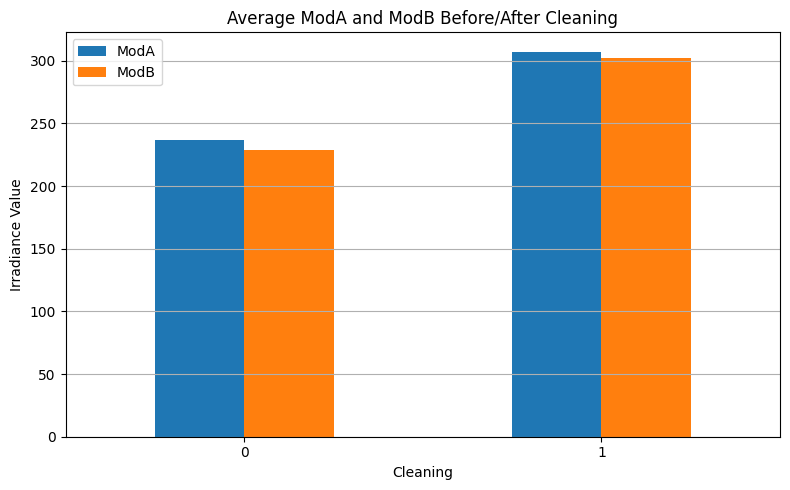

In [47]:
# Group by Cleaning and calculate mean
df_clean.groupby("Cleaning")[["ModA", "ModB"]].mean().plot(kind="bar", figsize=(8,5))
plt.title("Average ModA and ModB Before/After Cleaning")
plt.ylabel("Irradiance Value")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Average ModA & ModB by Cleaning Status

Insights:

Cleaning significantly improved the irradiance readings on both ModA and ModB sensors.

Before cleaning, sensor performance was noticeably lower, possibly due to dust or debris on panels.

Post-cleaning readings suggest better light capture, indicating maintenance has a measurable effect on energy output.

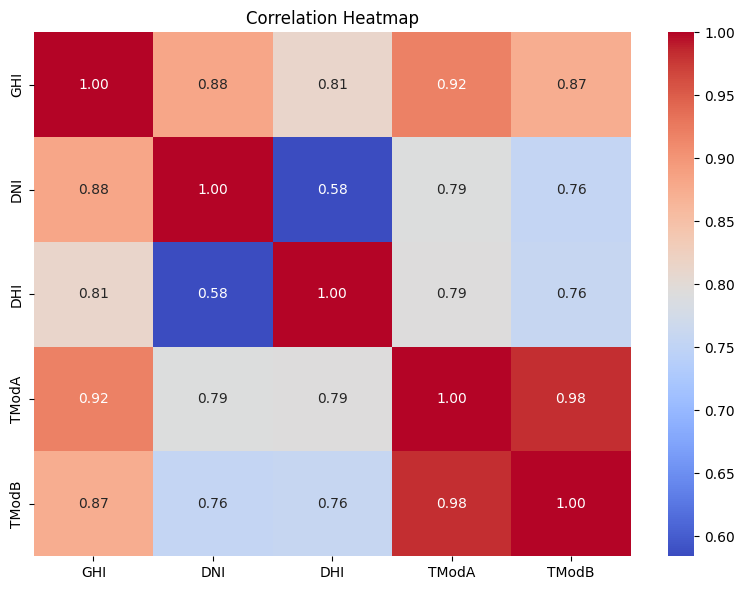

In [50]:
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
corr_matrix = df_clean[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


Correlation Heatmap
Insights:

GHI, DNI, and DHI are highly correlated, as expected, since they all measure solar irradiance in different components.

TModA and TModB show strong correlation, indicating sensor consistency.

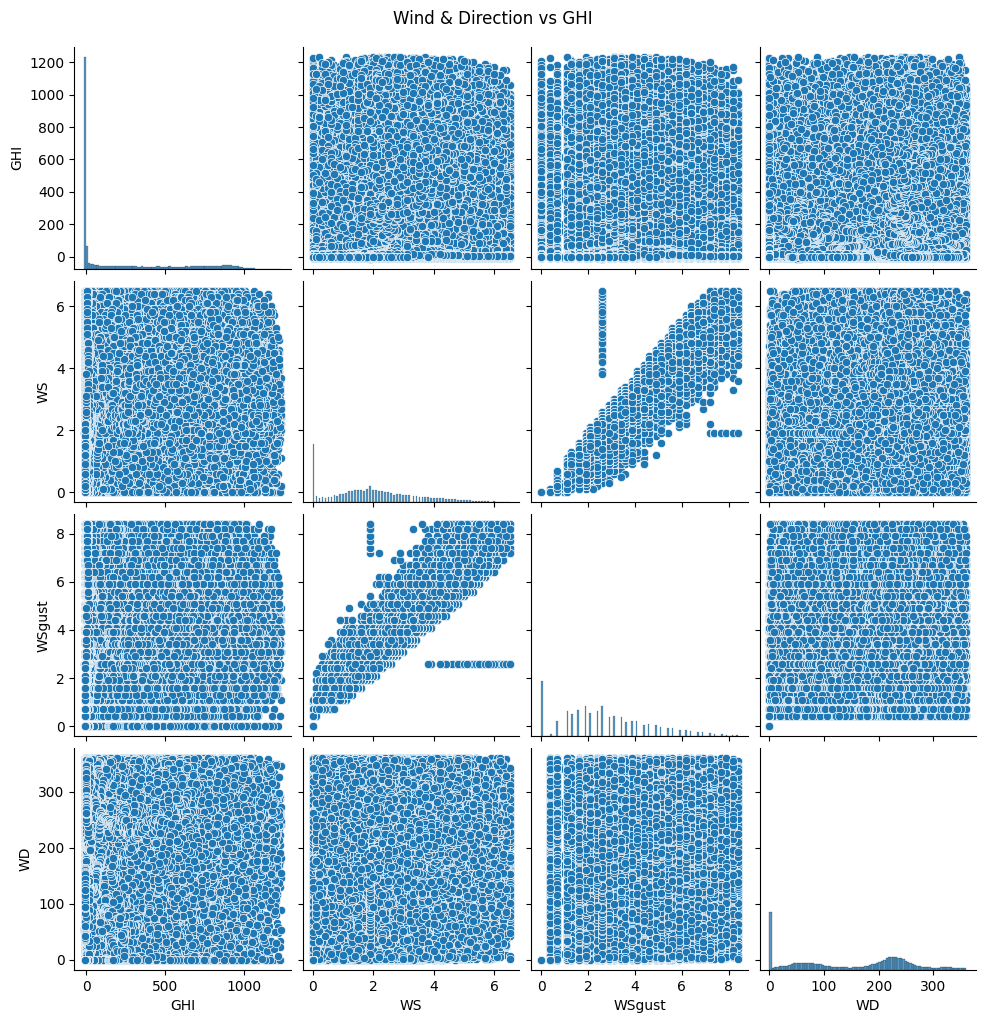

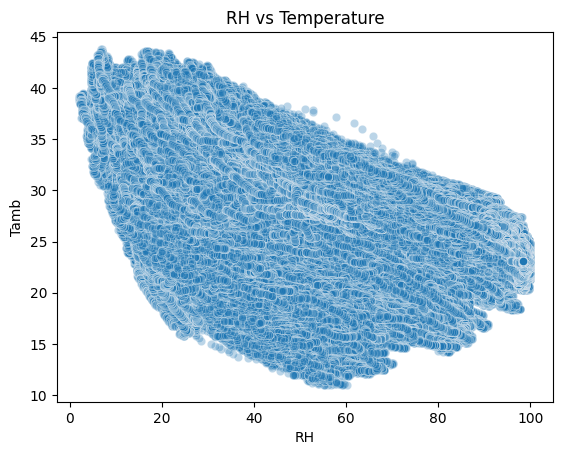

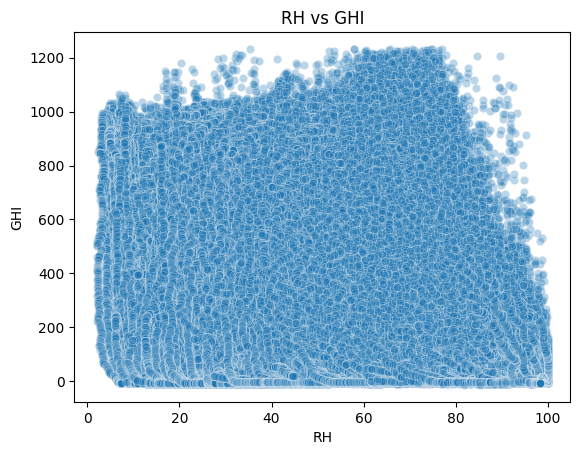

In [51]:
# WS, WSgust, WD vs GHI
sns.pairplot(df_clean[["GHI", "WS", "WSgust", "WD"]])
plt.suptitle("Wind & Direction vs GHI", y=1.02)
plt.show()

# RH vs Tamb, RH vs GHI
sns.scatterplot(x="RH", y="Tamb", data=df_clean, alpha=0.3)
plt.title("RH vs Temperature")
plt.show()

sns.scatterplot(x="RH", y="GHI", data=df_clean, alpha=0.3)
plt.title("RH vs GHI")
plt.show()


Wind Speed & Direction vs. GHI
Insights:

No strong correlation between wind speed (WS/WSgust) and GHI — wind does not directly impact irradiance.

Wind direction (WD) appears fairly uniformly distributed with some concentration from certain cardinal directions, which could inform solar panel tilt or dust accumulation patterns.

Relative humidity (RH) and Tamb show a slight inverse relationship: higher humidity often coincides with lower ambient temperature.

High RH can scatter sunlight, leading to a minor negative correlation with GHI, though impact is not dominant.

Useful for understanding cloud cover or early morning moisture effects.

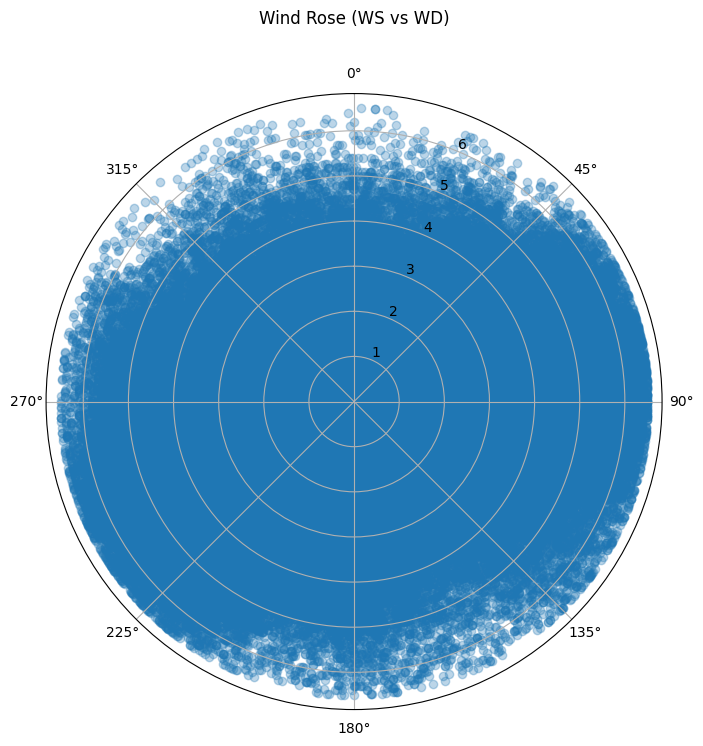

In [52]:
# Convert wind direction to radians
wind_dir_rad = np.deg2rad(df_clean["WD"])
wind_speed = df_clean["WS"]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.scatter(wind_dir_rad, wind_speed, alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Wind Rose (WS vs WD)", y=1.1)
plt.show()


Wind Rose (Polar Plot)
Insights:

Wind predominantly comes from all directions, with speeds mostly ranging between 4-6 m/s.

Understanding prevailing wind directions helps with positioning panels to reduce dust build-up and optimize maintenance cycles.

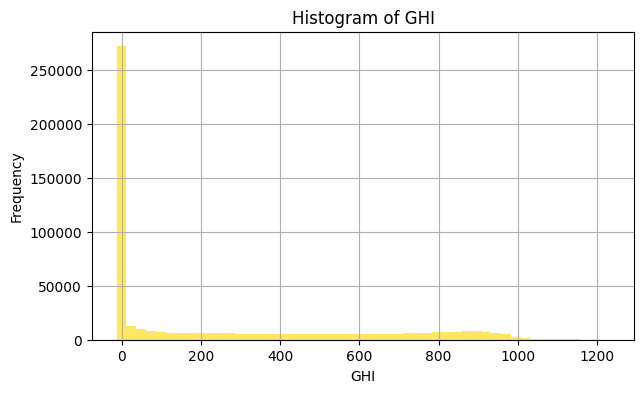

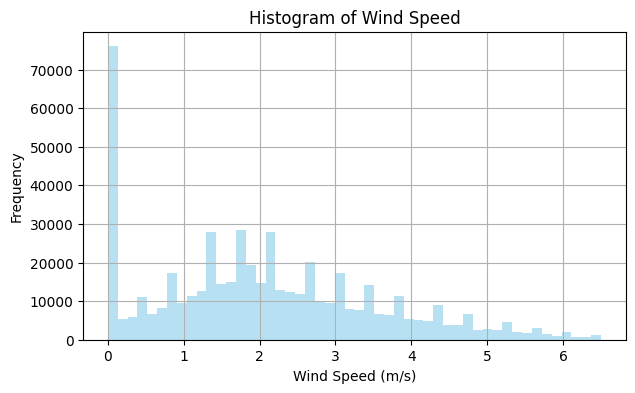

In [53]:
df_clean["GHI"].plot(kind="hist", bins=50, alpha=0.6, color="gold", title="Histogram of GHI", figsize=(7,4))
plt.xlabel("GHI")
plt.grid(True)
plt.show()

df_clean["WS"].plot(kind="hist", bins=50, alpha=0.6, color="skyblue", title="Histogram of Wind Speed", figsize=(7,4))
plt.xlabel("Wind Speed (m/s)")
plt.grid(True)
plt.show()

Histogram of GHI and Wind Speed
Insights:

GHI distribution shows a right-skewed pattern, suggesting seasonal or daily irradiance cycles.

Wind speed is mostly concentrated below 4 m/s, indicating generally calm conditions, favorable for stable panel operation.

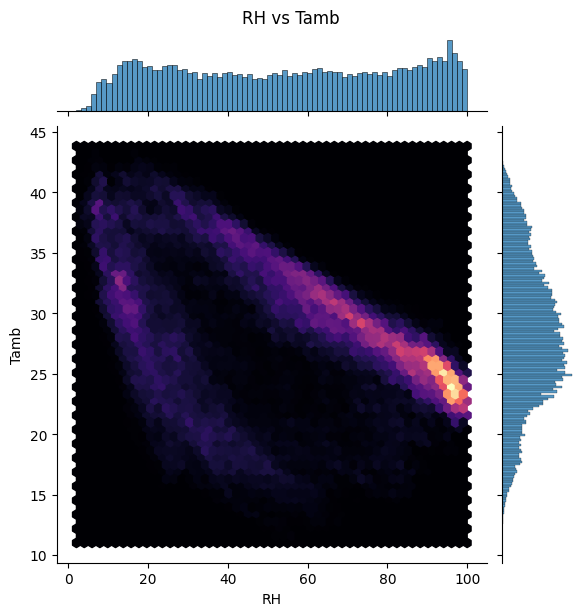

In [54]:
sns.jointplot(data=df_clean, x="RH", y="Tamb", kind="hex", cmap="magma")
plt.suptitle("RH vs Tamb", y=1.02)
plt.show()

Temperature Analysis (RH vs Tamb)
Insights:

High RH is associated with cooler temperatures, consistent with cloud cover or rainy conditions.

Temperature influences panel efficiency, so tracking RH helps identify potential cooling effects on the system.

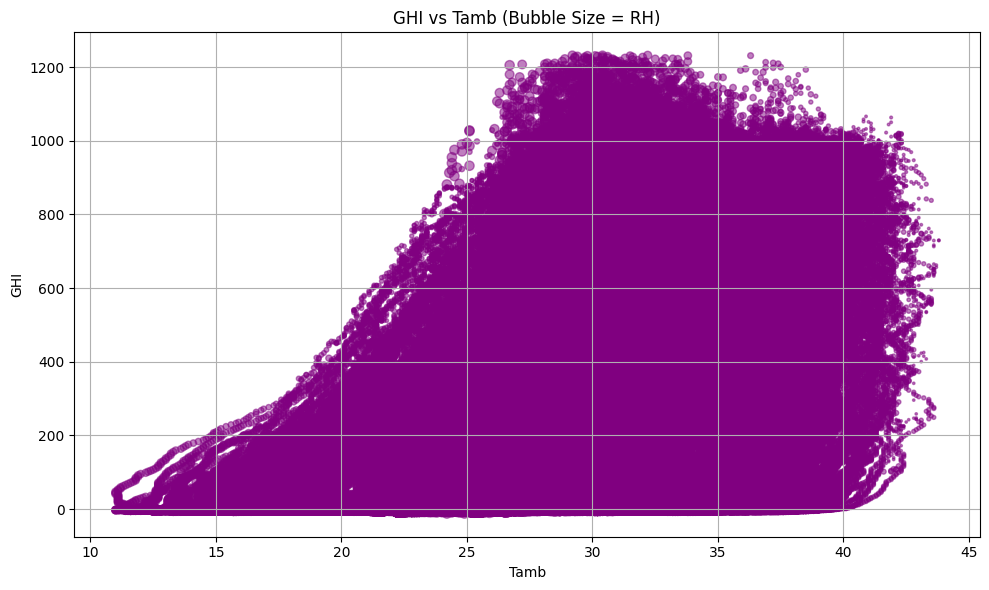

In [55]:
plt.figure(figsize=(10,6))
plt.scatter(df_clean["Tamb"], df_clean["GHI"], s=df_clean["RH"]*0.5, alpha=0.5, c="purple")
plt.xlabel("Tamb")
plt.ylabel("GHI")
plt.title("GHI vs Tamb (Bubble Size = RH)")
plt.grid(True)
plt.tight_layout()
plt.show()

Bubble Chart: GHI vs Tamb (Bubble = RH)
Insights:

GHI tends to rise with Tamb until a plateau, indicating increased solar energy with rising temperature.

Bubble size shows that higher humidity often appears at lower GHI levels, reinforcing earlier findings.

Useful for modeling energy efficiency under different atmospheric conditions.